In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import xgboost as xgb
import numpy as np

In [3]:
# Carregar o dataset
df = pd.read_csv('./datasets/casas_ponta_grossa.csv', delimiter=',')

# Retirando valores NaN:
df = df[df['Quartos'].notna()]
df = df[df['Banheiros'].notna()]
df = df[df['Suítes'].notna()]
df = df[df['Vagas de Garagem'].notna()]
df = df[df['Bairro'].notna()]
df = df[df['Área Total'].notna()]
dfFiltrado = df[df['Valor Venda'].notna()]

# Filtrando as casas com valor de venda entre 1 milhão e 5 milhões
dfFiltrado = dfFiltrado[(dfFiltrado['Valor Venda'] >= 1000000) & (dfFiltrado['Valor Venda'] <= 5000000)]

# Engenharia de Features
# Transformando a coluna 'Bairro' com LabelEncoder
le = LabelEncoder()
dfFiltrado['Bairro'] = le.fit_transform(dfFiltrado['Bairro'])

# Normalizando as variáveis numéricas
scaler = QuantileTransformer(output_distribution='normal')  # Usando QuantileTransformer para robustez
dfFiltrado[['Área Total', 'Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem']] = scaler.fit_transform(
    dfFiltrado[['Área Total', 'Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem']]
)

# Criando novas colunas
dfFiltrado['Preco por m2'] = dfFiltrado['Valor Venda'] / dfFiltrado['Área Total']
dfFiltrado['Faixa de Preço'] = pd.cut(dfFiltrado['Valor Venda'], bins=[1000000, 2000000, 3500000, 5000000], labels=['Baixo', 'Médio', 'Alto'])
dfFiltrado['Quartos por m2'] = dfFiltrado['Quartos'] / dfFiltrado['Área Total']
dfFiltrado['Banheiros por m2'] = dfFiltrado['Banheiros'] / dfFiltrado['Área Total']
dfFiltrado['Vagas de Garagem por m2'] = dfFiltrado['Vagas de Garagem'] / dfFiltrado['Área Total']

# Novas colunas sugeridas
dfFiltrado['Área Total * Quartos'] = dfFiltrado['Área Total'] * dfFiltrado['Quartos']
dfFiltrado['Área Total * Banheiros'] = dfFiltrado['Área Total'] * dfFiltrado['Banheiros']
dfFiltrado['Diferença Preço - Média Bairro'] = dfFiltrado['Valor Venda'] - dfFiltrado.groupby('Bairro')['Valor Venda'].transform('mean')
dfFiltrado['Bairro por Faixa de Preço'] = dfFiltrado['Bairro'] * dfFiltrado['Faixa de Preço'].cat.codes
dfFiltrado['Área por Quartos'] = dfFiltrado['Área Total'] / dfFiltrado['Quartos']
dfFiltrado['Área por Banheiros'] = dfFiltrado['Área Total'] / dfFiltrado['Banheiros']

# Convertendo a coluna 'Faixa de Preço' para valores numéricos (inteiros)
dfFiltrado['Faixa de Preço'] = dfFiltrado['Faixa de Preço'].cat.codes

# Verificação da coerência dos dados
# Verificar tipos de dados e valores nulos
print(dfFiltrado.info())

# Visualizar as primeiras linhas do dataset
print(dfFiltrado.head())


<class 'pandas.core.frame.DataFrame'>
Index: 284 entries, 17 to 3467
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Referência                      284 non-null    object 
 1   Quartos                         284 non-null    float64
 2   Banheiros                       284 non-null    float64
 3   Suítes                          284 non-null    float64
 4   Vagas de Garagem                284 non-null    float64
 5   Bairro                          284 non-null    int32  
 6   Área Total                      284 non-null    float64
 7   Valor Venda                     284 non-null    float64
 8   Preco por m2                    284 non-null    float64
 9   Faixa de Preço                  284 non-null    int8   
 10  Quartos por m2                  284 non-null    float64
 11  Banheiros por m2                284 non-null    float64
 12  Vagas de Garagem por m2         284 non

c:\Users\matheus.bernardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (284). n_quantiles is set to n_samples.
  warnings.warn(


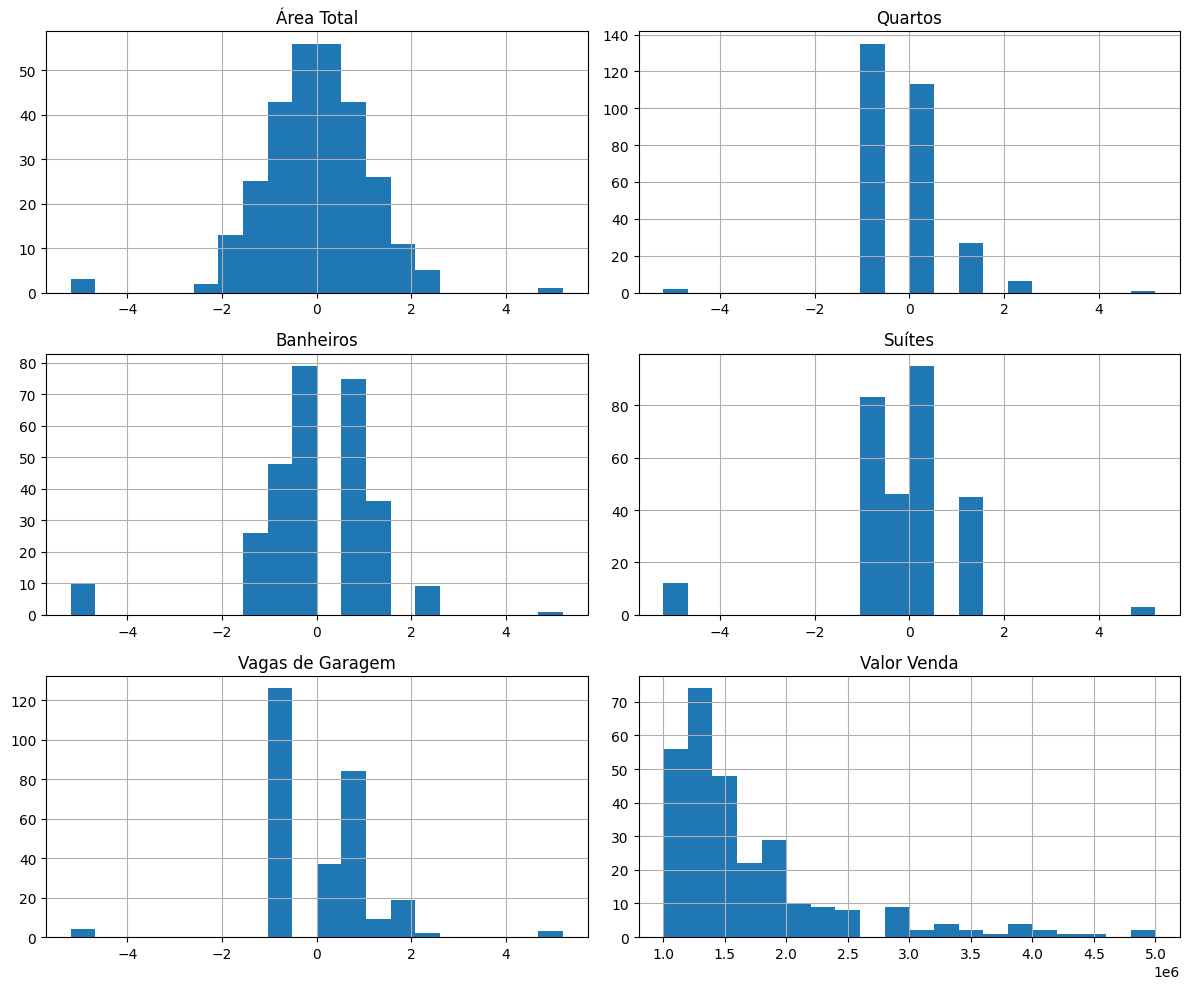

In [4]:
# Verificar a distribuição das variáveis numéricas
dfFiltrado[['Área Total', 'Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem', 'Valor Venda']].hist(bins=20, figsize=(12, 10))
plt.tight_layout()
plt.show()

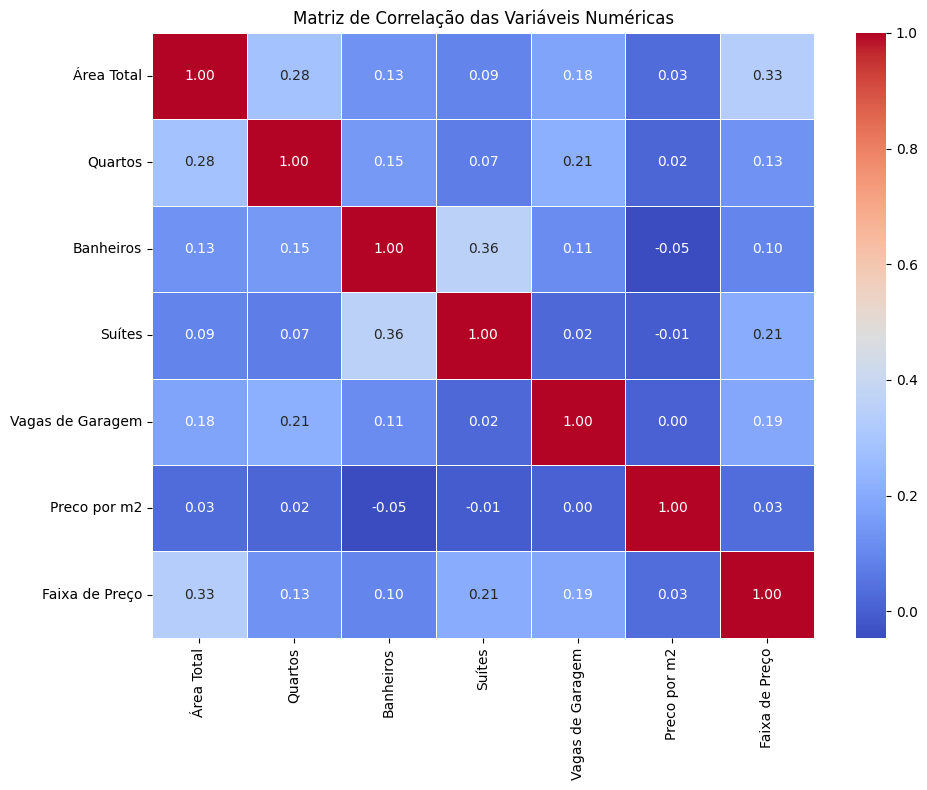

In [5]:
# Visualizar a correlação entre as variáveis numéricas
correlation_matrix = dfFiltrado[['Área Total', 'Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem', 'Preco por m2', 'Faixa de Preço']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.tight_layout()
plt.show()

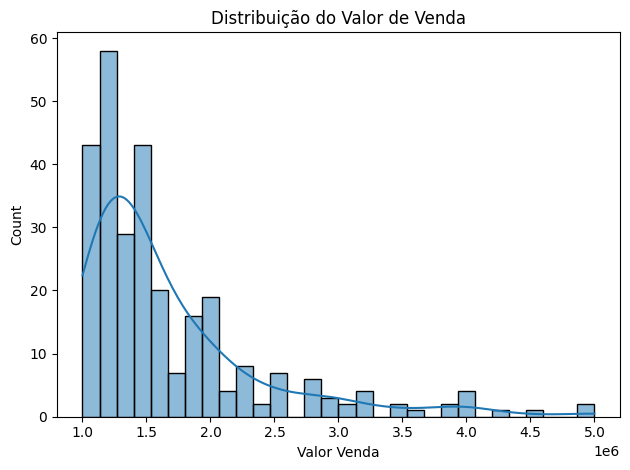

In [6]:
# Verificar a distribuição do preço
sns.histplot(dfFiltrado['Valor Venda'], kde=True, bins=30)
plt.title('Distribuição do Valor de Venda')
plt.tight_layout()
plt.show()

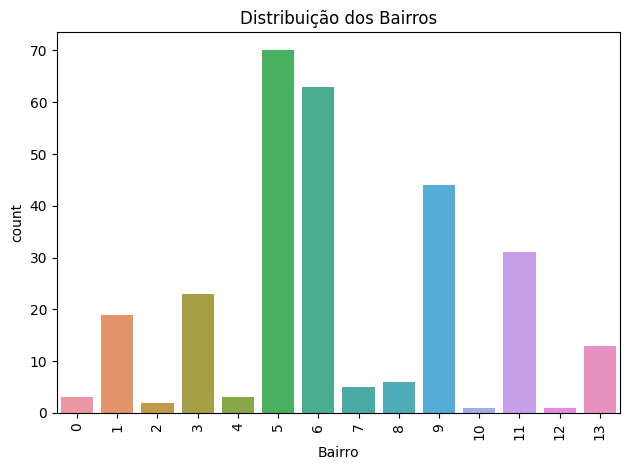

In [7]:
# Verificar a distribuição do bairro
sns.countplot(data=dfFiltrado, x='Bairro')
plt.title('Distribuição dos Bairros')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
# Visualizando os valores ausentes (antes da remoção)
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
print("Percentual de valores ausentes por coluna:\n", missing_values_percentage)

# Definindo as features (X) e o alvo (y)
X = dfFiltrado[['Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem', 'Bairro', 'Área Total', 'Preco por m2', 'Faixa de Preço', 
                'Quartos por m2', 'Banheiros por m2', 'Vagas de Garagem por m2', 'Área Total * Quartos', 
                'Área Total * Banheiros', 'Diferença Preço - Média Bairro', 'Bairro por Faixa de Preço', 
                'Área por Quartos', 'Área por Banheiros']]
y = dfFiltrado['Valor Venda']


Percentual de valores ausentes por coluna:
 Referência          0.0
Quartos             0.0
Banheiros           0.0
Suítes              0.0
Vagas de Garagem    0.0
Bairro              0.0
Área Total          0.0
Valor Venda         0.0
dtype: float64


In [9]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tuning de Hiperparâmetros com RandomizedSearchCV para o modelo XGBoost
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, cv=5, verbose=1, scoring='neg_mean_absolute_error', random_state=42)
xgb_random_search.fit(X_train, y_train)

# Melhor modelo XGBoost
best_xgb_model = xgb_random_search.best_estimator_

# Previsões e avaliação para XGBoost
y_pred_xgb = best_xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb}")
print(f"XGBoost - MAE: {mae_xgb}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost - RMSE: 131955.3321247353
XGBoost - MAE: 88781.97039473684


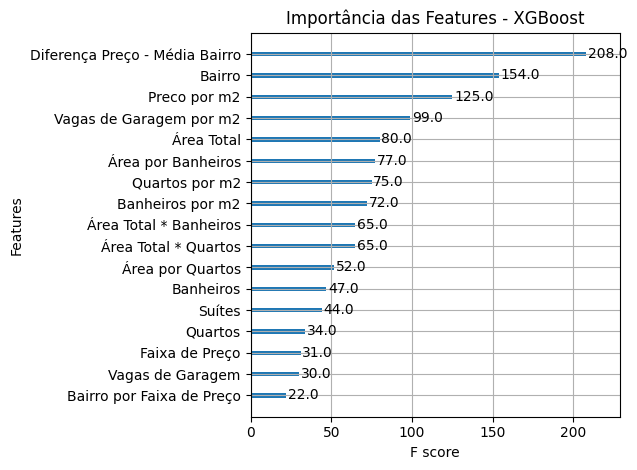

In [10]:

# Visualizando a importância das features com XGBoost
xgb.plot_importance(best_xgb_model)
plt.title('Importância das Features - XGBoost')
plt.tight_layout()
plt.show()